In [ ]:
# not sure about colab environment, may need to install
# !pip install torchtext

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from idlmam import set_seed

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
sns.set_theme()

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore #For attention mechanism use

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/ipykernel_15721/1977771978.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
# !conda install -c pytorch torchtext 
# !conda install -c powerai sentencepiece 
# !pip install  torchtext 
# !pip install  sentencepiece 

In [5]:
set_seed(42)

In [20]:
def get_pytorch_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')  # MPS is available on Apple Silicon Macs
    else:
        return torch.device('cpu')

device = get_pytorch_device()

# I found the mps gpu to be slower than the CPU, so uncomment the next line if you want to force the CPU
device = torch.device('cpu')

In [21]:
import torchtext
from torchtext.datasets import AG_NEWS

train_iter, test_iter = AG_NEWS(root='./data', split=('train', 'test'))
train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [22]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [23]:
### CHANGES 2024 Replace Vocab by vocab (new name in torchtext)

from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer('basic_english') #we will be fine with the default english style tokenizer

from collections import Counter #how many lines in this dataset
from torchtext.vocab import vocab #we need to create a vocabulary of all the words in the training set

counter = Counter() 
for (label, line) in train_dataset: #loop through the training data 
    counter.update(tokenizer(line)) #count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
vocab = vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) #create a vocab object, removing any word that didn't occur at least 10 times, and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"

### NEW - 2024
vocab.set_default_index(vocab['<unk>'])

In [24]:
def text_transform(x): #string -> list of integers
    return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handls unkown tokens for us, and we can make it pre and post-pend with the start and end markers respectively.

def label_transform(x): 
    return x-1 #labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3] 

#Transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1])) 

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 0, 17, 4, 18, 19, 20, 0, 21, 0, 17, 22, 23, 24, 25, 6, 2]


In [25]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset])) 
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)

padding_idx = vocab["<PAD>"]

embed_dim = 128
B = 64
epochs = 15

Vocab:  20647
Num Classes:  4


In [26]:
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch. 
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch] #get and transform every label in the batch
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
    #what is the longest sequence in this batch? 
    max_len = max([text.size(0) for text in texts])
    #pad each text tensor by whatever amount gets it to the max_len
    texts = [F.pad(text, (0,max_len-text.size(0)), value=padding_idx) for text in texts]
    #make x and y a single tensor
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
    
    return x, y

In [27]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [28]:
gru = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUM_CLASS), #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
gru_results = train_network(gru, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

dict_items([('GRU',     epoch   total time  train loss  val loss  train Accuracy  val Accuracy
0       0   429.358013    0.426027  0.277460        0.843700      0.902632
1       1   855.327745    0.218970  0.249006        0.924450      0.915000
2       2  1292.234244    0.157936  0.238776        0.945017      0.923421
3       3  1731.697866    0.111964  0.264926        0.961300      0.919079
4       4  2171.259552    0.076367  0.292816        0.973800      0.920921
5       5  2612.308719    0.053052  0.333150        0.981758      0.916316
6       6  3050.281737    0.040976  0.334310        0.986042      0.916842
7       7  3503.960562    0.029782  0.398929        0.989825      0.914211
8       8  3945.384766    0.026322  0.419726        0.991142      0.916316
9       9  4390.739278    0.022139  0.412602        0.992975      0.913421
10     10  4827.793431    0.020569  0.431369        0.992917      0.915263
11     11  5266.426317    0.019447  0.453910        0.993667      0.916711
12   

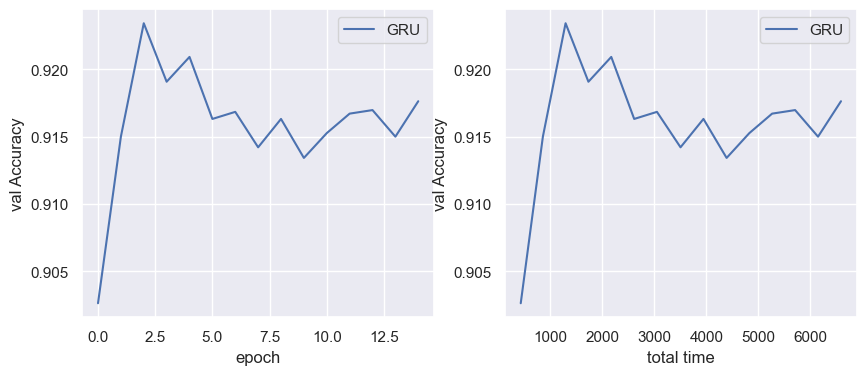

In [67]:
def make_plots(label_df_dict):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    for label,df in label_df_dict.items():
        sns.lineplot(x='epoch',y='val Accuracy',data=df,label=label,ax=ax[0]);
    for label,df in label_df_dict.items():    
        sns.lineplot(x='total time',y='val Accuracy',data=df,label=label,ax=ax[1]);


results_dict = {'GRU':gru_results}
make_plots(results_dict)

In [30]:
simpleEmbdAvg = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D) 
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.AdaptiveAvgPool2d((1,embed_dim)), #(B, T, D) -> (B, 1, D)
    nn.Flatten(), #(B, 1, D) -> (B, D)
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.BatchNorm1d(embed_dim),
    nn.Linear(embed_dim, NUM_CLASS)
)
simpleEmbdAvg_results = train_network(simpleEmbdAvg, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

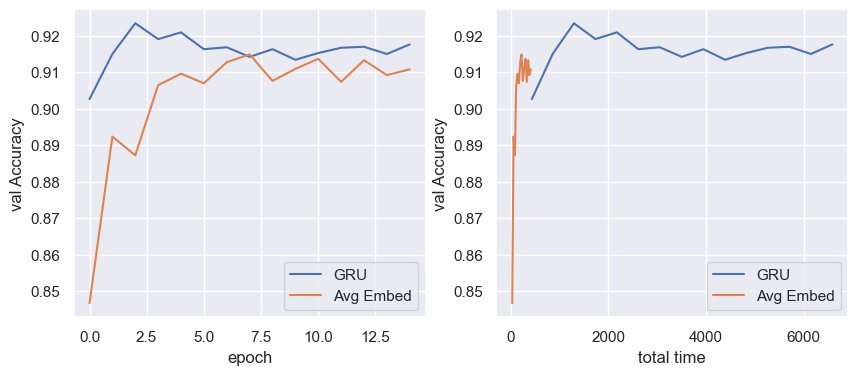

In [69]:
results_dict = {'GRU':gru_results, 'Avg Embed':simpleEmbdAvg_results}
make_plots(results_dict)

In [33]:
class EmbeddingAttentionBag(nn.Module):

    def __init__(self, vocab_size, D, embd_layers=3, padding_idx=None):
        super(EmbeddingAttentionBag, self).__init__()
        self.padding_idx = padding_idx
        self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
        if isinstance(embd_layers, int):
            self.embd_layers =  nn.Sequential( #(B, T, D) -> (B, T, D) 
                *[nn.Sequential(nn.Linear(embed_dim, embed_dim),
                nn.LeakyReLU()) for _ in range(embd_layers)]
            )
        else:
            self.embd_layers = embd_layers
        self.attn = AttentionAvg(AdditiveAttentionScore(D))# functions defined back in Chapter 10
    
    def forward(self, input):
        """
        input: (B, T) shape, dtype=int64
        output: (B, D) shape, dtype=float32
        """
        if self.padding_idx is not None:
            mask = input != self.padding_idx
        else:
            mask = input == input #All entries are `True`
        #mask is shape (B, T)
        x = self.embd(input) #(B, T, D)
        x = self.embd_layers(x)#(B, T, D)        
        #average over time
        context = x.sum(dim=1)/(mask.sum(dim=1).unsqueeze(1)+1e-5) #(B, T, D) -> (B, D)
        #If we wanted to just do normal averaging, we could return the context variable right now!
        return self.attn(x, context, mask=mask) # ((B, T, D), (B, D)) -> (B, D)

In [34]:
#Now we can define a simple model!
attnEmbd = nn.Sequential(
    EmbeddingAttentionBag(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, D) 
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.BatchNorm1d(embed_dim),
    nn.Linear(embed_dim, NUM_CLASS)
)
attnEmbd_results = train_network(attnEmbd, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

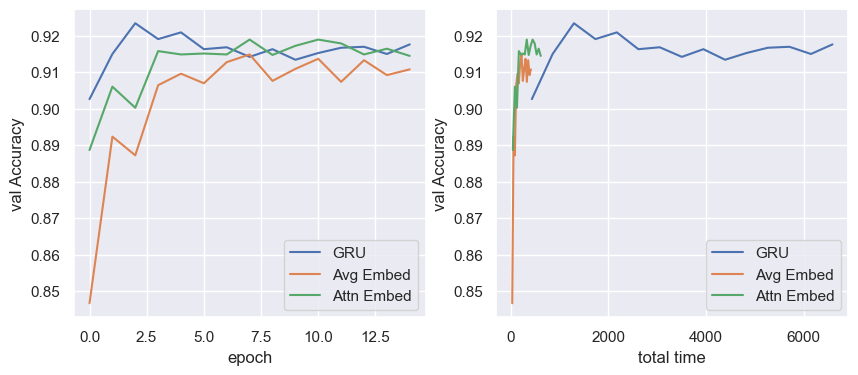

In [70]:
results_dict = {'GRU':gru_results, 
                'Avg Embed':simpleEmbdAvg_results,
                'Attn Embed':attnEmbd_results}

make_plots(results_dict)

In [36]:
def cnnLayer(in_size, out_size): #I'm being lazy, we should make k_size an argument too
    return nn.Sequential(
        nn.Conv1d(in_size, out_size, kernel_size=k_size, padding=k_size//2),
        nn.LeakyReLU(),
        nn.BatchNorm1d(out_size))

k_size = 3
cnnOverTime = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D) 
    LambdaLayer(lambda x : x.permute(0,2,1)), #(B, T, D) -> (B, D, T)
    #now we will pretend that D is the number of channels in this new interpreation of thed ata!
    cnnLayer(embed_dim, embed_dim),
    cnnLayer(embed_dim, embed_dim),
    nn.AvgPool1d(2), #(B, D, T) -> (B, D, T/2) 
    cnnLayer(embed_dim, embed_dim*2),
    cnnLayer(embed_dim*2, embed_dim*2),
    nn.AvgPool1d(2), #(B, 2*D, T/2) -> (B, 2*D, T/4) 
    cnnLayer(embed_dim*2, embed_dim*4),
    cnnLayer(embed_dim*4, embed_dim*4),
    #Now that we have done some rounds of pooling and convolution, reduce to a fixed length!
    nn.AdaptiveMaxPool1d(1), #(B, 4*D, T/4) -> (B, 4*D, 1)
    nn.Flatten(), #(B, 4*D, 1) -> (B, 4*D)
    nn.Linear(4*embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.BatchNorm1d(embed_dim),
    nn.Linear(embed_dim, NUM_CLASS)
)
cnn_results = train_network(cnnOverTime, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

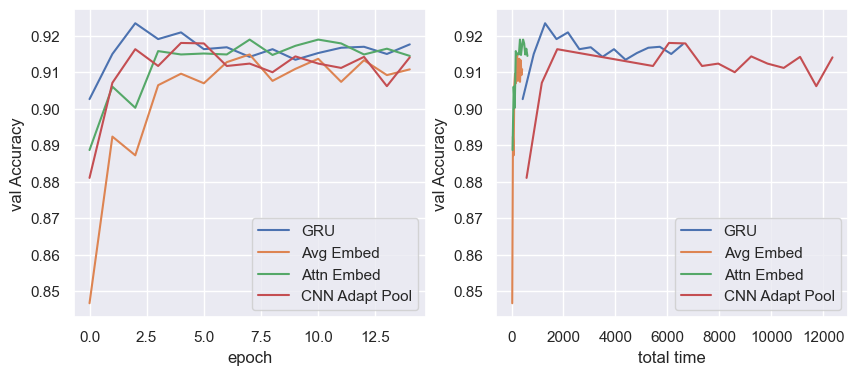

In [71]:
results_dict = {'GRU':gru_results, 
                'Avg Embed':simpleEmbdAvg_results,
                'Attn Embed':attnEmbd_results,
                'CNN Adapt Pool':cnn_results}

make_plots(results_dict)

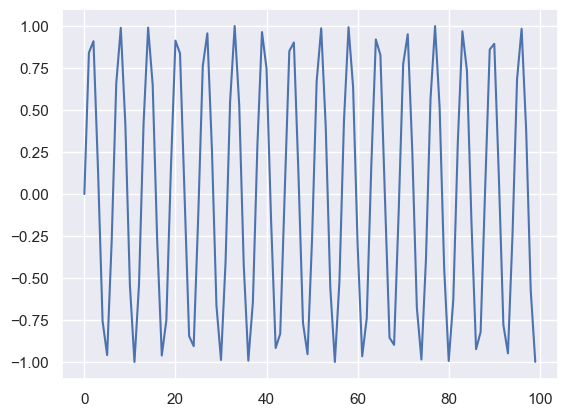

In [72]:
position = np.arange(0, 100)
plt.plot(position, np.sin(position), label="sin(position)");

<Axes: >

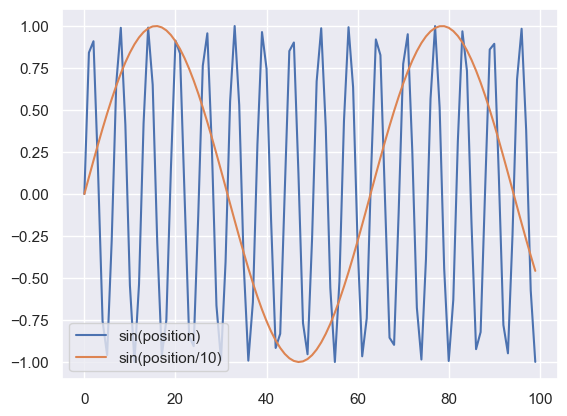

In [73]:
position = np.arange(0, 100)
sns.lineplot(x=position, y=np.sin(position), label="sin(position)")
sns.lineplot(x=position, y=np.sin(position/10), label="sin(position/10)")

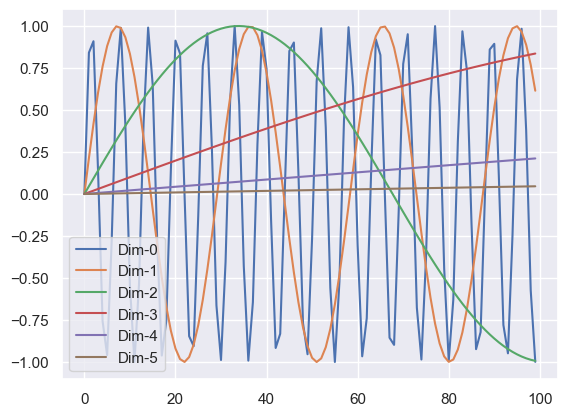

In [74]:
dimensions = 6 
position = np.expand_dims(np.arange(0, 100), 1)
#this computes the frequency f in a numerically stable way. 
div = np.exp(np.arange(0, dimensions*2, 2) * (-math.log(10000.0) / (dimensions*2)))
for i in range(dimensions):
    sns.lineplot(x=position[:,0], y=np.sin(position*div)[:,i], label="Dim-"+str(i))

In [41]:
#Adapted from from https://github.com/pytorch/examples/blob/0c1654d6913f77f09c0505fb284d977d89c17c1a/word_language_model/model.py#L63
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        self.batch_first = batch_first

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        if self.batch_first: #go from (B, T, D) input shape to (T, B, D)
            x = x.permute(1, 0, 2)

        x = x *np.sqrt(self.d_model) + self.pe[:x.size(0), :]
        x = self.dropout(x)
        
        if self.batch_first: #now go back to (B, T, D) shape
            x = x.permute(1, 0, 2)
            
        return x

In [42]:
simplePosEmbdAvg = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D) 
    PositionalEncoding(embed_dim, batch_first=True),
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.AdaptiveAvgPool2d((1,None)), #(B, T, D) -> (B, 1, D)
    nn.Flatten(), #(B, 1, D) -> (B, D)
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.BatchNorm1d(embed_dim),
    nn.Linear(embed_dim, NUM_CLASS)
)

In [43]:
embd_layers =  nn.Sequential( #(B, T, D) -> (B, T, D) 
    *([PositionalEncoding(embed_dim, batch_first=True)]+
      [nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.LeakyReLU()) for _ in range(3)])
)

attnPosEmbd = nn.Sequential(
    EmbeddingAttentionBag(VOCAB_SIZE, embed_dim, padding_idx=padding_idx, embd_layers=embd_layers), #(B, T) -> (B, D) 
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.BatchNorm1d(embed_dim),
    nn.Linear(embed_dim, NUM_CLASS)
)

posEmbdAvg_results = train_network(simplePosEmbdAvg, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)
attnPosEmbd_results = train_network(attnPosEmbd, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

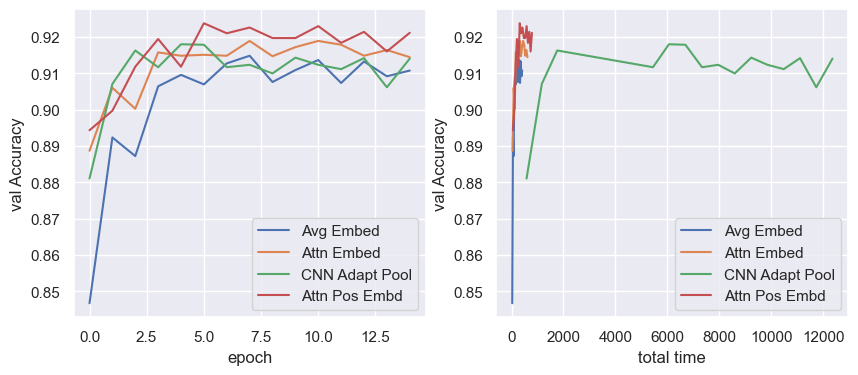

In [76]:
results_dict = {'Avg Embed':simpleEmbdAvg_results,
                'Attn Embed':attnEmbd_results,
                'CNN Adapt Pool':cnn_results,
                'Attn Pos Embd':attnPosEmbd_results}

make_plots(results_dict)

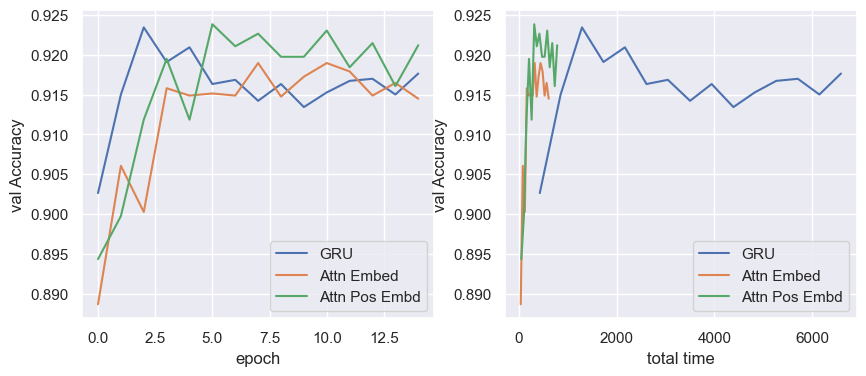

In [77]:
results_dict = {'GRU':gru_results,
                'Attn Embed':attnEmbd_results,
                'Attn Pos Embd':attnPosEmbd_results}

make_plots(results_dict)

In [46]:
class SimpleTransformerClassifier(nn.Module):

    def __init__(self, vocab_size, D, padding_idx=None):
        super(SimpleTransformerClassifier, self).__init__()
        self.padding_idx = padding_idx
        self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
        self.position = PositionalEncoding(D, batch_first=True)
        #This below line is the main work for our transformer implementation!
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=D, nhead=8),num_layers=3)
        self.attn = AttentionAvg(AdditiveAttentionScore(D))
        self.pred = nn.Sequential(
            nn.Flatten(), #(B, 1, D) -> (B, D)
            nn.Linear(D, D),
            nn.LeakyReLU(),
            nn.BatchNorm1d(D),
            nn.Linear(D, NUM_CLASS)
        )
    
    def forward(self, input):
        if self.padding_idx is not None:
            mask = input != self.padding_idx
        else:
            mask = input == input #All entries are `True`
        x = self.embd(input) #(B, T, D)
        x = self.position(x) #(B, T, D)
        #Because the resut of our code is (B, T, D), but transformers 
        #take input as (T, B, D), we will have to permute the order 
        #of the dimensions before and after 
        x = self.transformer(x.permute(1,0,2)) #(T, B, D)
        x = x.permute(1,0,2) #(B, T, D)
        #average over time
        context = x.sum(dim=1)/mask.sum(dim=1).unsqueeze(1)
        return self.pred(self.attn(x, context, mask=mask))
#Build and train this model!    
simpleTransformer = SimpleTransformerClassifier(VOCAB_SIZE, embed_dim, padding_idx=padding_idx)
transformer_results = train_network(simpleTransformer, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

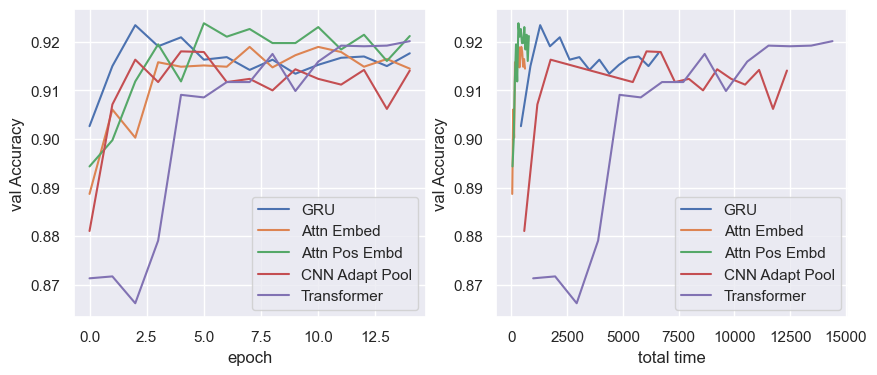

In [78]:
results_dict = {'GRU':gru_results,
                'Attn Embed':attnEmbd_results,
                'Attn Pos Embd':attnPosEmbd_results,
                'CNN Adapt Pool':cnn_results,
                'Transformer':transformer_results}

make_plots(results_dict)